In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from utils.storage.truth_db import SQLiteTruthSaver
from utils.storage.bluesky_db import SQLiteBlueSkySaver

## 0. Extracting Graphs and Subgraphs

In [2]:
#Truth_Graph = SQLiteTruthSaver().extract_network()
#nx.write_gexf(Truth_Graph, "truth.gexf")

# Bluesky_Graph = SQLiteBlueSkySaver().extract_network()
# nx.write_gexf(Bluesky_Graph, "bluesky.gexf")

Truth_Graph = nx.read_gexf("truth.gexf")
Bluesky_Graph = nx.read_gexf("bluesky.gexf")

Truth_TopGraph = SQLiteTruthSaver().extract_network(top_k=1000)
nx.write_gexf(Truth_TopGraph, "truth_top1000.gexf")

Bluesky_TopGraph = SQLiteBlueSkySaver().extract_network(top_k=1000)
nx.write_gexf(Bluesky_TopGraph, "bluesky_top1000.gexf")

## 1. Basic Measures

Order, Size, Degree Distribution and Connected Components

In [21]:
def analyze_graph(G):
    print(f"{G.order()} Nodes and {G.size()} Edges")
    print(f"Density is {nx.density(G)}")

    degree = dict(G.degree())
    degree_values = list(degree.values())

    np.arange(min(degree_values),max(degree_values)+1)
    count, bins = np.histogram(degree_values, bins=np.arange(min(degree_values),max(degree_values)+2))

    pdf = count / G.order()
    fig = plt.figure(figsize=(8,4))
    plt.xlim([1, 15000])
    plt.plot(bins[:-1], pdf)
    plt.xscale('log')
    plt.xlabel('Grado', size=15, weight='bold')
    plt.ylabel('% Nodi', size=15, weight='bold')


    print(f"Min Degree: {min(degree_values)}")
    print(f"Max Degree: {max(degree_values)}")
    print(f"Average Degree: {np.mean(degree_values)}")

    cc = list(nx.connected_components(G.to_undirected()))
    print(f"There are {len(cc)} Connected Components:")
    for component in sorted(cc, key=len, reverse=True)[:min(3, len(cc))]:
        print(f"\tConnected Component of size: {len(component)}")
    print("\t...")

    print("Degree Distribution:")
    plt.show()

29291 Nodes and 51447 Edges
Density is 5.9966193878991e-05
Min Degree: 1
Max Degree: 13481
Average Degree: 3.512819637431293
There are 8 Connected Components:
	Connected Component of size: 29275
	Connected Component of size: 3
	Connected Component of size: 3
	...
Degree Distribution:


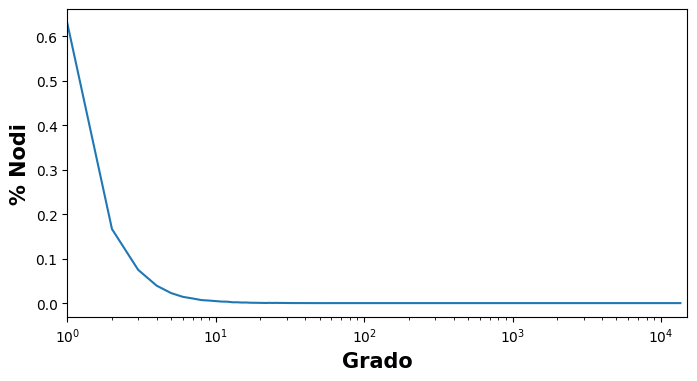

In [22]:
analyze_graph(Truth_Graph)

14735 Nodes and 17607 Edges
Density is 8.109882435492535e-05
Min Degree: 1
Max Degree: 1148
Average Degree: 2.38982015609094
There are 240 Connected Components:
	Connected Component of size: 13957
	Connected Component of size: 21
	Connected Component of size: 19
	...
Degree Distribution:


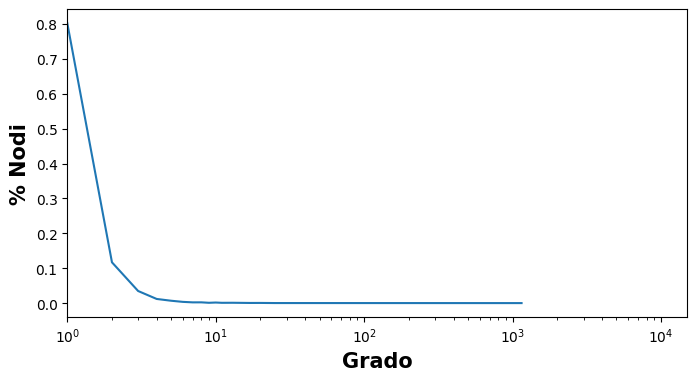

In [23]:
analyze_graph(Bluesky_Graph)

993 Nodes and 4384 Edges
Density is 0.004450508397492122
Min Degree: 1
Max Degree: 641
Average Degree: 8.829808660624371
There are 2 Connected Components:
	Connected Component of size: 992
	Connected Component of size: 1
	...
Degree Distribution:


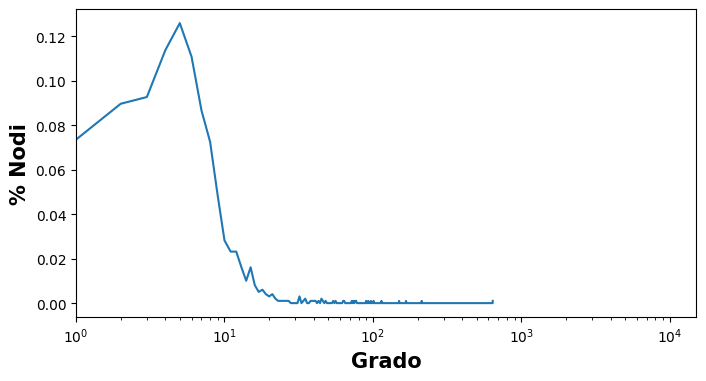

In [25]:
analyze_graph(Truth_TopGraph)

925 Nodes and 1787 Edges
Density is 0.0020907920907920906
Min Degree: 1
Max Degree: 179
Average Degree: 3.863783783783784
There are 15 Connected Components:
	Connected Component of size: 910
	Connected Component of size: 2
	Connected Component of size: 1
	...
Degree Distribution:


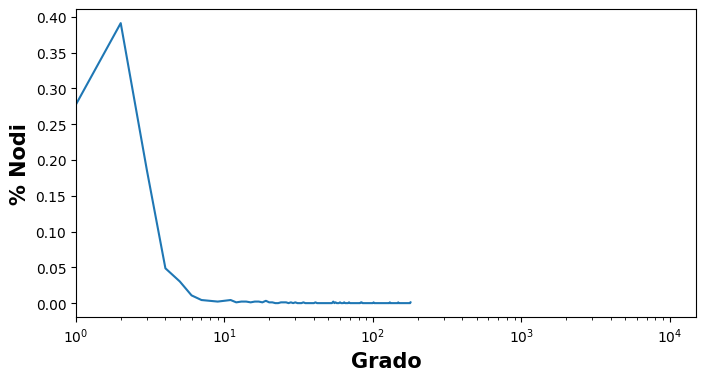

In [26]:
analyze_graph(Bluesky_TopGraph)